<h1 STYLE="padding-left:1em;text-align: center;">Projet 08 : Participez à une competition Kaggle </h1>

# Introduction

<p STYLE="padding-left:1em;text-align:justify;"> Ce notebook présente le deuxième modèle soumis sur la plateforme Kaggle dans le cadre de la compétition UW-Madison GI Tract Image Segmentation : Track healthy organs in medical scans to improve cancer treatment. <br><br>
Il porte sur la segmentation des intestins et de l'estomac sur les clichés d'IRMs afin d'éviter ses organes lors du traitement de la tumeur par radiothérapie.<br><br>
Dans ce notebook nous avons augmenté la dimenension des images en entrée de modèle et ajouter des étapes d'encodage et de décodage dans l'algorithme U-NET.  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

* Part 1: [Train --> uwmgtis Keras train_02](https://www.kaggle.com/code/benoitdacosta/uwmgtis-keras-train-02) 
* Part 2: [Inference --> uwmgtis Keras infer_02](https://www.kaggle.com/code/benoitdacosta/uwmgtis-keras-infer-02)

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies et configuration </b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Preprocessing </b></a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Fonctions</b></a><br>
<a href="#4" STYLE="padding-left:1em;color:black"><b>Etape 4 : DATASET</b></a><br>
<a href="#5" STYLE="padding-left:1em;color:black"><b>Etape 5 : FOLDS</b></a><br>
<a href="#6" STYLE="padding-left:1em;color:black"><b>Etape 6 : Metrics</b></a><br>
<a href="#7" STYLE="padding-left:1em;color:black"><b>Etape 7 : U-NET Models</b></a><br>
<a href="#7" STYLE="padding-left:1em;color:black"><b>Etape 8 : Prediction</b></a><br>

# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies et configuration

In [2]:
import warnings
warnings.filterwarnings("ignore")

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from pathlib import Path
import os 
from glob import glob
from joblib import parallel_backend, Parallel, delayed , dump , load
from tqdm import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm
import gc

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose,\
                         Concatenate, Input , Dropout, Lambda
from keras.models import Model , load_model

# from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import cv2

import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

Number of processors:  8


In [3]:
# repertory ='/kaggle/input/'
# DIR = repertory + 'uw-madison-gi-tract-image-segmentation/' 


path_colab = os.path.abspath('')+'/drive/MyDrive/Colab Notebooks/P08'
sep = '/'if os.path.isdir(path_colab) else '\\'
repertory = path_colab if os.path.isdir(path_colab) else os.path.abspath('')
DIR = repertory+f'{sep}uw-madison-gi-tract-image-segmentation{sep}' 

TRAIN_DIR = DIR + 'train'
TEST_DIR = DIR + 'test'
train_csv = DIR +'train.csv' 
sample_sub = DIR + 'sample_submission.csv'

df_train = pd.read_csv(train_csv)
df_train.head(10)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN
6,case123_day20_slice_0003,large_bowel,NaN
7,case123_day20_slice_0003,small_bowel,NaN
8,case123_day20_slice_0003,stomach,NaN
9,case123_day20_slice_0004,large_bowel,NaN


In [4]:
class CFG:
    BATCH_SIZE    = 32
    img_size      = (256, 256, 3)
    n_fold        = 5
    fold_selected = 1
    epochs        = 100
    seed          = 42
    nb_cpu        = mp.cpu_count()
    steps_per_epoch_train = None
    steps_per_epoch_val = None

# <a STYLE="color:black" id="2"> Etape 2 : Preprocessing

In [5]:
# Metadata
def preprocessing(df, subset = 'train'):
    #--------------------------------------------------------------------------
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    #--------------------------------------------------------------------------
    if subset == 'train':
        all_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
        x = all_images[0].rsplit(sep , 4)[0] ## ../uw-madison-gi-tract-image-segmentation/train
    else: 
        all_images = glob(os.path.join(TEST_DIR, "**", "*.png"), recursive=True)
        x = all_images[0].rsplit(sep , 4)[0] ## ../uw-madison-gi-tract-image-segmentation/test

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images
    #--------------------------------------------------------------------------
    df = pd.merge(df,tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    df["px_spacing_h"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df 

In [6]:
train_df = preprocessing(df_train)
train_df.head()

,id,class,segmentation,case,day,slice,path,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5


# <a STYLE="color:black" id="3">Etape 3 : Fonction

In [7]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
def id2mask(id_):
    itrain_df = train_df[train_df['id']==id_]
    wh = itrain_df[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        ctrain_df = itrain_df[itrain_df['class']==class_]
        rle = ctrain_df.segmentation.squeeze()
        if len(ctrain_df) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

In [9]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

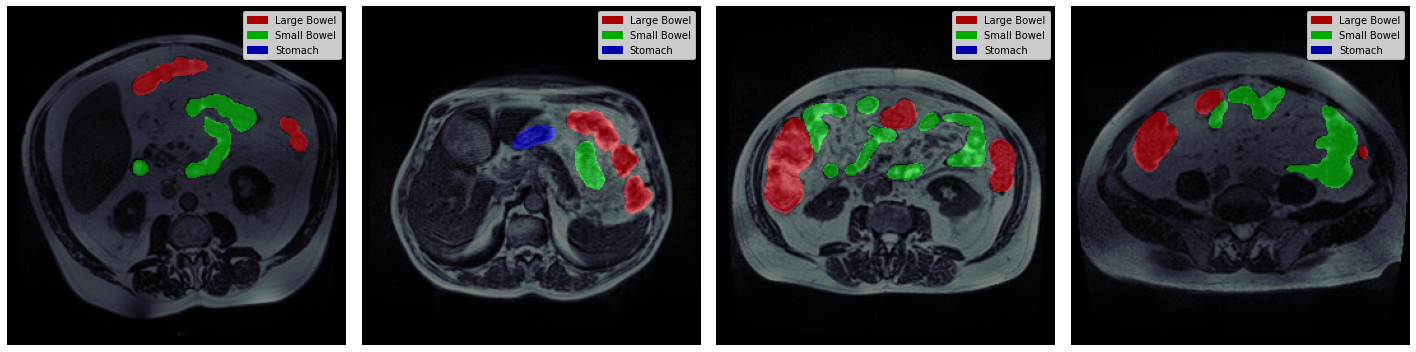

In [10]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(train_df[train_df.segmentation.notna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(train_df[train_df['id']==id_].path.iloc[0])
    mask = id2mask(id_)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

In [11]:
# Restructure
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
        
    display(df_out.sample(5))
    return df_out

In [12]:
DF_train= restructure(train_df, subset="train")

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
31828,case144_day15_slice_0101,31457 3 31722 5 31986 10 32251 13 32516 15 32781 17 33046 19 33310 22 33574 24 33839 26 34104 27 34369 28 34634 29 34900 28 35165 29 35431 28 35696 27 35961 25 36227 24 36492 25 36757 26 37023 26 ...,27262 5 27527 7 27791 9 28043 8 28053 14 28306 29 28570 52 28835 57 29100 65 29366 71 29631 75 29897 80 30162 83 30428 85 30693 88 30960 89 31226 90 31494 88 31762 23 31795 53 32029 18 32068 46 32...,,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case144\case144_day15\scans\slice_0101_266_266_1.50_1.50.png,144,15,0101,266,266,2
3235,case88_day36_slice_0068,,,,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case88\case88_day36\scans\slice_0068_360_310_1.50_1.50.png,88,36,0068,360,310,0
19623,case24_day25_slice_0072,21703 3 21968 6 22233 8 22498 12 22764 14 23030 17 23296 20 23562 21 23828 22 24094 22 24360 22 24627 21 24893 21 25159 21 25426 19 25693 11 25960 5 32363 5 32626 9 32891 10 33157 11 33422 12 3368...,25151 5 25415 8 25677 14 25941 17 26206 19 26237 2 26471 36 26736 38 27002 39 27267 41 27533 41 27798 43 28064 43 28330 44 28595 45 28861 46 29127 46 29393 46 29659 46 29925 46 30191 45 30457 45 3...,20350 10 20614 13 20879 16 21143 19 21408 21 21672 23 21937 25 22202 26 22466 28 22731 29 22997 28 23263 28 23528 28 23794 27 24060 27 24327 25 24593 24 24859 23 25125 21 25392 18 25659 14 25927 10,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case24\case24_day25\scans\slice_0072_266_266_1.50_1.50.png,24,25,0072,266,266,3
3584,case44_day0_slice_0129,,,,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case44\case44_day0\scans\slice_0129_266_266_1.50_1.50.png,44,0,0129,266,266,0
7565,case63_day18_slice_0142,,,,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case63\case63_day18\scans\slice_0142_266_266_1.50_1.50.png,63,18,0142,266,266,0


# <a STYLE="color:black" id="4">Etape 4 : DATASET

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = CFG.BATCH_SIZE, subset="train", shuffle=False , img_shape = CFG.img_size):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,self.img_shape[0],self.img_shape[1],self.img_shape[2]))
        y = np.empty((self.batch_size,self.img_shape[0],self.img_shape[1],self.img_shape[2]))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        id_, heights, widths, classes = [] , [] ,[], [] 
        
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            if self.subset != 'train':
                id_.append(self.df['id'].iloc[indexes[i]])
                heights.append(self.df['height'].iloc[indexes[i]])
                widths.append(self.df['width'].iloc[indexes[i]])
                classes.append(self.df['class'].iloc[indexes[i]])
            
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            
            img = self.__load_grayscale(img_path)  
            X[i,] = img   
            
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, self.img_shape[0:2] )
                    y[i,:,:,k] = mask
                    
        if self.subset == 'train':
            return X, y
        else: 
            return X , id_ , widths , heights , classes

    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
#         img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
        dsize = self.img_shape[0:2]
        img = cv2.resize(img, dsize)
#         img = img.astype(np.int8) / 255.
        img = img.astype('float32') # original is uint16
        img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
        img = img.astype('uint8')/255
        img = np.expand_dims(img, axis=-1)
        return img

In [14]:
Train_masks = list(DF_train[DF_train['large_bowel']!=''].index)
Train_masks += list(DF_train[DF_train['small_bowel']!=''].index)
Train_masks += list(DF_train[DF_train['stomach']!=''].index)

DF_training = DF_train[DF_train.index.isin(Train_masks)]
DF_training.reset_index(inplace=True, drop = True)
print(DF_training.shape)

(16590, 11)


# <a STYLE="color:black" id="5">Etape 5 : FOLDS

In [15]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(skf.split(X=DF_training, y=DF_training['count'],groups =DF_training['case']), 1):
    DF_training.loc[val_idx, 'fold'] = fold
    
# DF_training['fold'] = DF_training['fold'].astype(np.uint8)

train_idx = DF_training[DF_training["fold"]!=CFG.fold_selected].index
valid_idx = DF_training[DF_training["fold"]==CFG.fold_selected].index

# CFG.steps_per_epoch_train = len(train_idx) // CFG.BATCH_SIZE 
# if len(train_idx) % CFG.BATCH_SIZE !=0: 
#     CFG.steps_per_epoch_train +=1
    
# CFG.steps_per_epoch_val = len(valid_idx) //CFG.BATCH_SIZE
# if len(valid_idx) //CFG.BATCH_SIZE !=0: 
#     CFG.steps_per_epoch_val +=1

train_generator = DataGenerator(DF_training[DF_training.index.isin(train_idx)],batch_size = CFG.BATCH_SIZE , shuffle=True)
val_generator = DataGenerator(DF_training[DF_training.index.isin(valid_idx)], batch_size = CFG.BATCH_SIZE)

display(DF_training.groupby('fold').size())
display(DF_training.groupby(['fold','count'])['id'].count())

fold
1.0    3973
2.0    2806
3.0    3656
4.0    3121
5.0    3034
dtype: int64

fold  count
1.0   1         556
      2        2664
      3         753
2.0   1         362
      2        1843
      3         601
3.0   1         607
      2        2348
      3         701
4.0   1         566
      2        2018
      3         537
5.0   1         377
      2        2048
      3         609
Name: id, dtype: int64

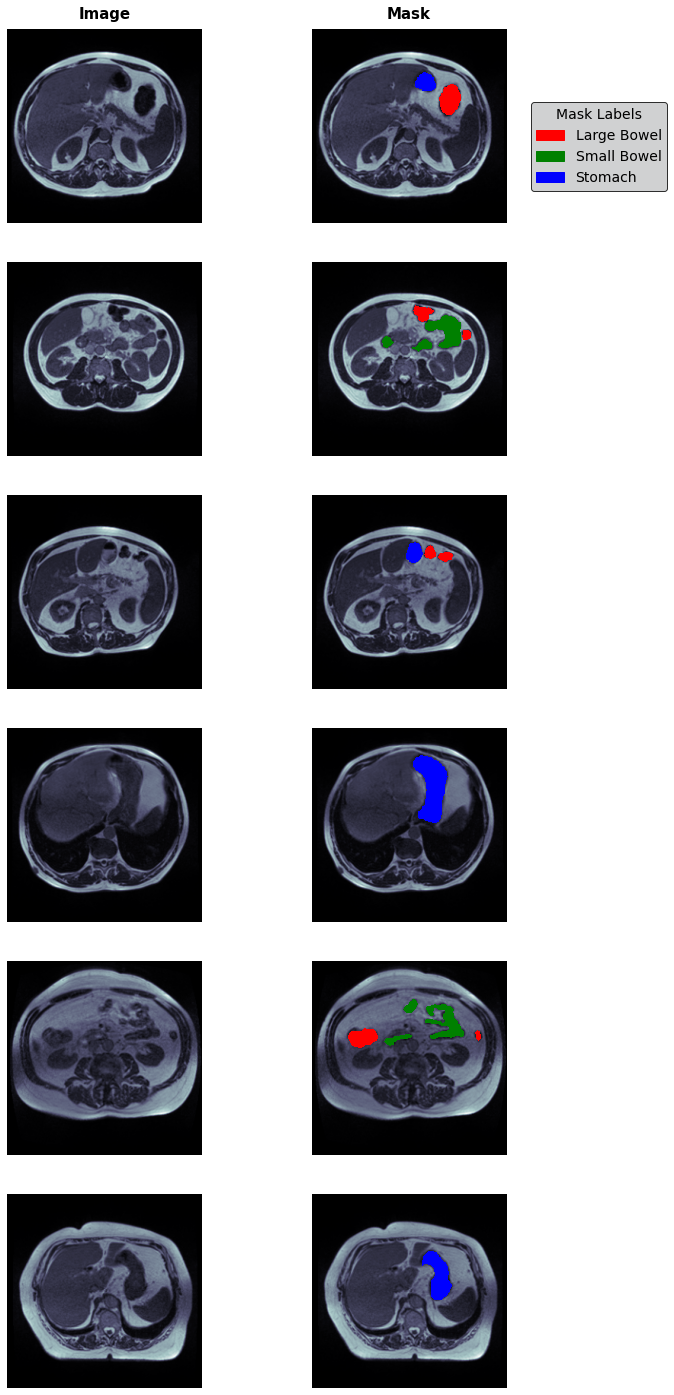

In [16]:
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['red','green','blue']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = train_generator[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# <a STYLE="color:black" id="6">Etape 6 : Metrics

In [17]:
#Metrics
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


# <a STYLE="color:black" id="7">Etape 7 : U-NET Models

In [18]:
def conv_block(input, num_filters, batchnorm ):
    x = Conv2D(num_filters, kernel_size = (3,3), padding="same",)(input)
    if batchnorm : 
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, kernel_size = (3,3), padding="same")(x)
    if batchnorm : 
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters, dropout = False ,  batchnorm =True):
    x = conv_block(input, num_filters , batchnorm)
    p = MaxPool2D((2, 2))(x)
    if dropout : 
        p = Dropout(0.3)(p)
    return x, p

def decoder_block(input, skip_features, num_filters, dropout = False, batchnorm = True):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    if dropout : 
        x = Dropout(0.3)(x)
    x = conv_block(x, num_filters, batchnorm)
    return x

def build_unet(input_shape, dropout = False , batchnorm = True , activation = 'sigmoid'):

    inputs = Input(shape=input_shape)
    
    s0, p0 = encoder_block(inputs, 32 , dropout , batchnorm )
    s1, p1 = encoder_block(p0, 64 , dropout , batchnorm )
    s2, p2 = encoder_block(p1, 128, dropout , batchnorm  )
    s3, p3 = encoder_block(p2, 256, dropout , batchnorm )
    s4, p4 = encoder_block(p3, 512, dropout , batchnorm )
    s5, p5 = encoder_block(p4, 1024, dropout , batchnorm )


    b1 = conv_block(p5, 2048, batchnorm  )

    d0 = decoder_block(b1, s5, 1024, dropout , batchnorm )
    d1 = decoder_block(d0, s4, 512, dropout , batchnorm )
    d2 = decoder_block(d1, s3, 256, dropout , batchnorm )
    d3 = decoder_block(d2, s2, 128, dropout , batchnorm )
    d4 = decoder_block(d3, s1, 64, dropout , batchnorm )
    d5 = decoder_block(d4, s0, 32, dropout , batchnorm )

    outputs = Conv2D(3, 1, padding="same", activation =activation )(d5)

    model = Model(inputs, outputs, name="U-Net")

    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=bce_dice_loss,
                  metrics=[iou_coef , dice_coef])
    return model

# PLOT TRAINING
def plot_train(model):
    losses = model if isinstance(model, pd.DataFrame) else pd.DataFrame(model.history.history) 
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(losses['loss'].index,losses['loss'],label='Train_Loss')
    plt.plot(losses['val_loss'].index,losses['val_loss'],label='Val_loss')
    plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

    plt.subplot(1,3,2)
    plt.plot(losses['dice_coef'].index,losses['dice_coef'],label='Train_dice_coef')
    plt.plot(losses['val_dice_coef'].index,losses['val_dice_coef'],label='Val_dice_coef')
    plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

    plt.subplot(1,3,3)
    plt.plot(losses['iou_coef'].index,losses['iou_coef'],label='Train_iou_coef')
    plt.plot(losses['val_iou_coef'].index,losses['val_iou_coef'],label='Val_iou_coef')
    plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
    plt.show()

def fit_model(model ,  model_name , train_dataset , validation_dataset ):
    if os.path.isfile(models_path+str(model_name)+'.h5'): 
        model = load_model(models_path+str(model_name)+'.h5', custom_objects={'bce_dice_loss': bce_dice_loss ,'iou_coef':iou_coef ,'dice_coef':dice_coef  })
        results = load(results_path+'score_'+str(model_name)+'.joblib')
        # model.summary()
        plot_train(results)

    else :
        # model.summary()
        early_stop = EarlyStopping(monitor='val_loss', patience=5)
        model.fit(train_dataset, epochs=CFG.epochs, validation_data=validation_dataset, callbacks=[early_stop])
                 
        results = pd.DataFrame(model.history.history)
        plot_train(model)
        
        dump(results,results_path+'score_'+str(model_name)+'.joblib',compress = True)
        model.save(models_path+str(model_name)+'.h5') 
    
    return model , results

In [19]:
models_path = repertory+sep+'Models'+sep
results_path = repertory+sep+'Results'+sep

# Kaggle
# models_path = '/kaggle/working/'
# results_path = '/kaggle/working/'

In [20]:
input_shape = CFG.img_size
model = build_unet(input_shape, dropout = True , batchnorm = True) 
gc.collect()

364

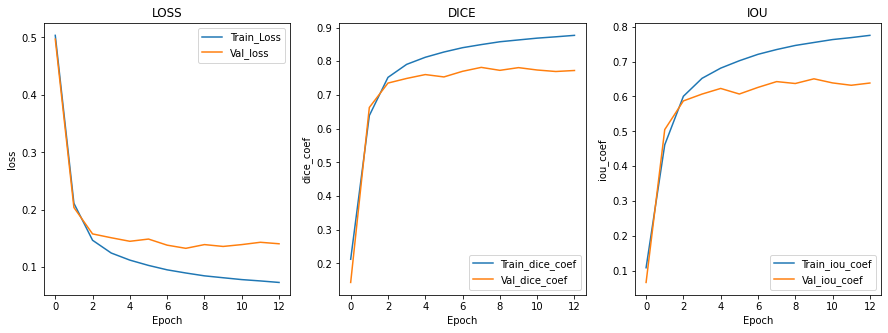

In [21]:
model , results = fit_model(model , 'U-net_M2',train_generator , val_generator)

In [22]:
results

,loss,iou_coef,dice_coef,val_loss,val_iou_coef,val_dice_coef
0,0.503583,0.108179,0.212191,0.497012,0.065941,0.143385
1,0.211332,0.461232,0.638755,0.204012,0.504953,0.662777
2,0.147045,0.600616,0.752147,0.158100,0.587317,0.735229
3,0.124849,0.652183,0.790734,0.151420,0.606949,0.748962
4,0.112482,0.681456,0.811806,0.145249,0.623137,0.760463
5,0.103269,0.702685,0.827421,0.149127,0.607132,0.753460
6,0.095581,0.721111,0.840274,0.138516,0.626135,0.770163
7,0.090094,0.734852,0.849458,0.133007,0.642774,0.781820
8,0.085124,0.746611,0.857865,0.139492,0.637303,0.773041
9,0.081825,0.755117,0.863298,0.136285,0.650769,0.781069


# Prediction

In [22]:
sub_df = pd.read_csv(sample_sub)
if not len(sub_df):
    debug = True
    sub_df = pd.read_csv(train_csv)
    test_df = preprocessing(df_train,  subset = 'train')
    test_df = test_df[:1000*3]
else : 
    debug = False
    test_df = preprocessing(sub_df , subset = 'test')
    path_load_infer = repertory+'uwmgtis-keras-train-01/'

    models_path = path_load_infer 
    results_path = path_load_infer
    input_shape = CFG.img_size
    model = build_unet(input_shape, dropout = True , batchnorm = True)
    model , results = fit_model(model , 'U-net', None, None)
    
test_df.head(5)

,id,class,segmentation,case,day,slice,path,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5


In [23]:
def infer(DF , model , batch_size = CFG.BATCH_SIZE) : 
    pred_rle = []; pred_ids = []; pred_classes = [];
    
    DF_batch = DataGenerator(DF, batch_size =batch_size, subset="test", shuffle=False)
    for idx , (img , id_, widths , heights , classes) in enumerate(tqdm(DF_batch)):
#         msk = np.empty((batch_size,CFG.img_size[0],CFG.img_size[1],CFG.img_size[2]))
                                       
        preds = model.predict(img,verbose=0)
        
        # Rle encode 
        for j in range(batch_size):
            k = 0 if classes[j]=='large_bowel' else 1 if classes[j]=='small_bowel' else 2

            pred_img = cv2.resize(preds[j,:,:,k], ( widths[j] , heights[j]),
                                  interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify

            pred_ids.append(id_[j])
            pred_classes.append(classes[j])
            pred_rle.append(rle_encode(pred_img))
    
    return pred_rle, pred_ids , pred_classes

In [24]:
CFG.BATCH_SIZE = 3   
pred_rle, pred_ids , pred_classes = infer(test_df, model, batch_size = CFG.BATCH_SIZE)

  0%|          | 0/93 [00:00<?, ?it/s]

In [25]:
submission = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_rle
})

if debug :
    sub_df = pd.read_csv(train_csv)
    del sub_df['segmentation']
else:
    sub_df = pd.read_csv(sample_sub)
    del sub_df['predicted']

sub_df = sub_df.merge(submission, on=['id','class'])
sub_df.to_csv('submission.csv',index=False)

submission.sample(10)

,id,class,predicted
1573,case77_day20_slice_0093,small_bowel,
1749,case77_day0_slice_0008,large_bowel,39055 3 39320 4 39585 4
2498,case77_day18_slice_0113,stomach,
1846,case77_day0_slice_0040,small_bowel,
665,case123_day22_slice_0078,stomach,14781 4 15045 13 15308 18 15573 21 15838 24 16103 26 16369 27 16634 29 16900 30 17166 30 17432 31 17697 32 17963 33 18229 33 18495 34 18761 34 19027 34 19294 33 19560 33 19826 33 20092 34 20359 33...
2819,case133_day0_slice_0076,stomach,
256,case123_day20_slice_0086,small_bowel,20902 4 21165 9 21431 9 21696 12 21961 14 22227 14 22492 16 22758 17 22990 4 23023 19 23255 6 23290 19 23520 7 23557 20 23786 7 23824 20 24053 5 24090 22 24320 4 24357 22 24624 22 24891 21 25157 2...
348,case123_day20_slice_0117,large_bowel,25332 6 25596 9 25862 10 26127 12 26393 15 26409 7 26554 3 26659 25 26817 8 26925 26 27082 10 27191 27 27347 11 27458 27 27613 12 27724 27 27879 12 27989 28 28145 12 28255 28 28411 11 28521 28 286...
1723,case77_day20_slice_0143,small_bowel,20105 9 20369 13 20633 16 20897 18 21145 36 21411 36 21670 44 21935 45 22199 47 22464 48 22519 4 22729 49 22783 17 22995 50 23047 21 23261 74 23526 76 23792 77 24058 79 24324 80 24590 82 24857 83 ...
2261,case77_day18_slice_0034,stomach,
